In [1]:
#%env CUDA_VISIBLE_DEVICES=-1
%load_ext autoreload
%autoreload 2
from plot_utils import *
import sys
import os
from PIL import Image
import itertools

In [2]:
datasets = ["bicycle","bonsai","drjohnson","train"]
eval_paths = {}
for exp in os.listdir("../output"):
        eval_paths[exp] = {"training ckpt" : {}, "mini_s" : {}, "c3dgs" : {}, 
                           "light_prune_0.66_1_0.1_v_important_score" : {}, 
                           "light_prune_0.66_1_0.1_v_important_score_distill" : {}, 
                           "light_prune_0.66_1_0.1_v_important_score_distill_vq" : {},
                           "light_prune_0.8_1_0.1_v_important_score" : {}, 
                           "light_prune_0.8_1_0.1_v_important_score_distill" : {}, 
                           "light_prune_0.8_1_0.1_v_important_score_distill_vq" : {},
                           "light_prune_0.66_1_0.2_v_important_score" : {}, 
                           "light_prune_0.66_1_0.2_v_important_score_distill" : {}, 
                           "light_prune_0.66_1_0.2_v_important_score_distill_vq" : {}}

        for ds in datasets:

            
            p = os.path.join("../output",exp,ds,"test","ours_30000")
            if os.path.exists(p):
                eval_paths[exp]["training ckpt"][ds] = p
            
            for key in eval_paths[exp].keys():
                p = os.path.join("../output",exp,key,ds,"test","ours_30000")
                if os.path.exists(p):
                    eval_paths[exp][key][ds] = p
                
                p = os.path.join("../output",exp,key,ds,"test","ours_35000")
                if os.path.exists(p):
                    eval_paths[exp][key][ds] = p

                p = os.path.join("../output",exp,key,ds,"test","ours_5000")
                if os.path.exists(p):
                    eval_paths[exp][key][ds] = p

                p = os.path.join("../output",exp,key,ds,"test","ours_10000")
                if os.path.exists(p):
                    eval_paths[exp][key][ds] = p

                p = os.path.join("../output",exp,key,ds,"test","ours_None")
                if os.path.exists(p):
                    eval_paths[exp][key][ds] = p
            """
            p_mini = os.path.join("../output",exp,"mini_s",ds,"test","ours_30000")
            if os.path.exists(p_mini):
                eval_paths[exp]["mini_s"][ds] = p_mini

            p_c3dgs = os.path.join("../output",exp,"c3dgs",ds,"test","ours_35000")
            if os.path.exists(p_c3dgs):
                eval_paths[exp]["c3dgs"][ds] = p_c3dgs

            p_lightprune = os.path.join("../output",exp,"light_prune_0.66_1_0.1_v_important_score",ds,"test","ours_5000")
            if os.path.exists(p_lightprune):
                eval_paths[exp]["light_prune_0.66_1_0.1_v_important_score"][ds] = p_lightprune

            p_lightprunedistill = os.path.join("../output",exp,"light_prune_0.66_1_0.1_v_important_score_distill",ds,"test","ours_10000")
            if os.path.exists(p_lightprunedistill):
                eval_paths[exp]["light_prune_0.66_1_0.1_v_important_score_distill"][ds] = p_lightprunedistill

            p_lightprunedistillvq = os.path.join("../output",exp,"light_prune_0.66_1_0.1_v_important_score_distill_vq",ds,"test","ours_None")
            if os.path.exists(p_lightprunedistillvq):
                eval_paths[exp]["light_prune_0.66_1_0.1_v_important_score_distill_vq"][ds] = p_lightprunedistillvq
            """
eval_paths = transform_keys(eval_paths,{"light_prune_0.66_1_0.1_v_important_score" : "light prune",
                                        "light_prune_0.66_1_0.1_v_important_score_distill" : "light prune + distill",
                                        "light_prune_0.66_1_0.1_v_important_score_distill_vq" : "light prune + distill + vq",
                                        "light_prune_0.8_1_0.1_v_important_score" : "light prune 2",
                                        "light_prune_0.8_1_0.1_v_important_score_distill" : "light prune 2 + distill",
                                        "light_prune_0.8_1_0.1_v_important_score_distill_vq" : "light prune 2 + distill + vq",
                                        "light_prune_0.66_1_0.2_v_important_score" : "light prune 3",
                                        "light_prune_0.66_1_0.2_v_important_score_distill" : "light prune 3 + distill",
                                        "light_prune_0.66_1_0.2_v_important_score_distill_vq" : "light prune 3 + distill + vq",
                                        "mini_compact3d" : "mini + compact3d", "compact3d" : "compact3d", "mini_opacity" : "mini + opacity reg.", "orig_depth_reg" : "3dgs + depth reg.", "orig_opacity" : "3dgs + opacity reg.", "orig" : "3dgs"})
stats = load_stats(eval_paths)
normalized_stats,min_max = normalize_stats(stats,datasets)
get_storage(stats,eval_paths)

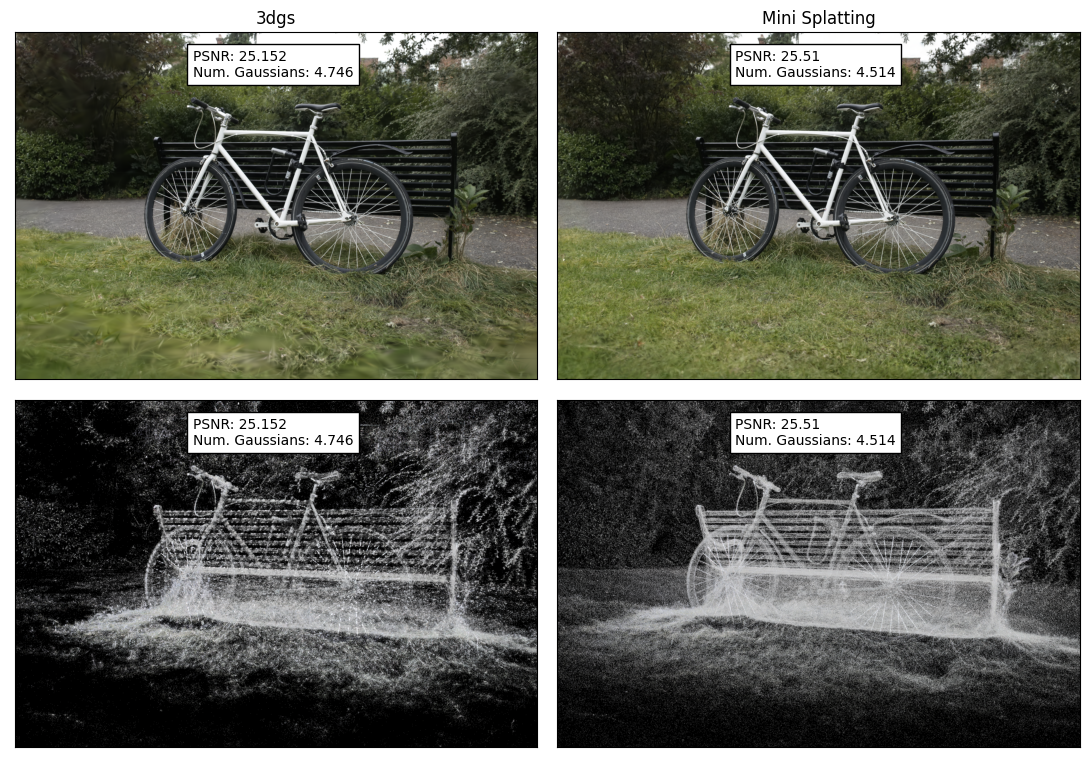

In [5]:
# Plot the density (where are gaussians where not) for a specific image from the bicycle dataset for 3dgsinal,Mini Splatting and Compact3D
import sys
import os
sys.path.insert(0, os.path.join(sys.path[0], "../"))
import torch
from utils.image_utils import psnr
from lpipsPyTorch import lpips
from utils.loss_utils import l1_loss, ssim

fig,axs = plt.subplots(2,2)
remove_ticks = lambda *axs : [(ax.set_xticks([]),ax.set_xticklabels([]),ax.set_yticks([]),ax.set_yticklabels([])) for ax in axs]
comp = "training ckpt"
for x,render in enumerate(["renders","density"]):
    for y,exp in enumerate(["3dgs","mini"]):
        render_img = Image.open(os.path.join(eval_paths[exp][comp]["bicycle"],render,"00000.png"))
        gt_img = Image.open(os.path.join(eval_paths[exp][comp]["bicycle"],"gt","00000.png"))
        psnr_val = round(psnr(torch.tensor(np.asarray(render_img)/255).permute(2,0,1),torch.tensor(np.asarray(gt_img)/255).permute(2,0,1)).mean().double().cpu().detach().numpy().item(),3)
        psnr_val = round(stats[exp][comp]["bicycle"]["psnr"],3)
        num_gauss = round(stats[exp][comp]["bicycle"]["num_gaussians"]/1e6,3)
        axs[x][y].imshow(render_img)
        axs[x][y].text(0.34, 0.95, f"PSNR: {psnr_val} \nNum. Gaussians: {num_gauss}", transform=axs[x][y].transAxes, fontsize=10,verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

    #axs[x][0].set_ylabel(comp,fontsize=12)
remove_ticks(*[ax for ax in axs.flatten()])

axs[0][0].set_title("3dgs")
axs[0][1].set_title("Mini Splatting")

fig.set_size_inches(11,7.75)
fig.tight_layout()
fig.savefig('./plots/mini_densify.png', dpi=600,bbox_inches="tight")
fig.savefig('./plots/mini_densify_lowq.png', dpi=100,bbox_inches="tight")

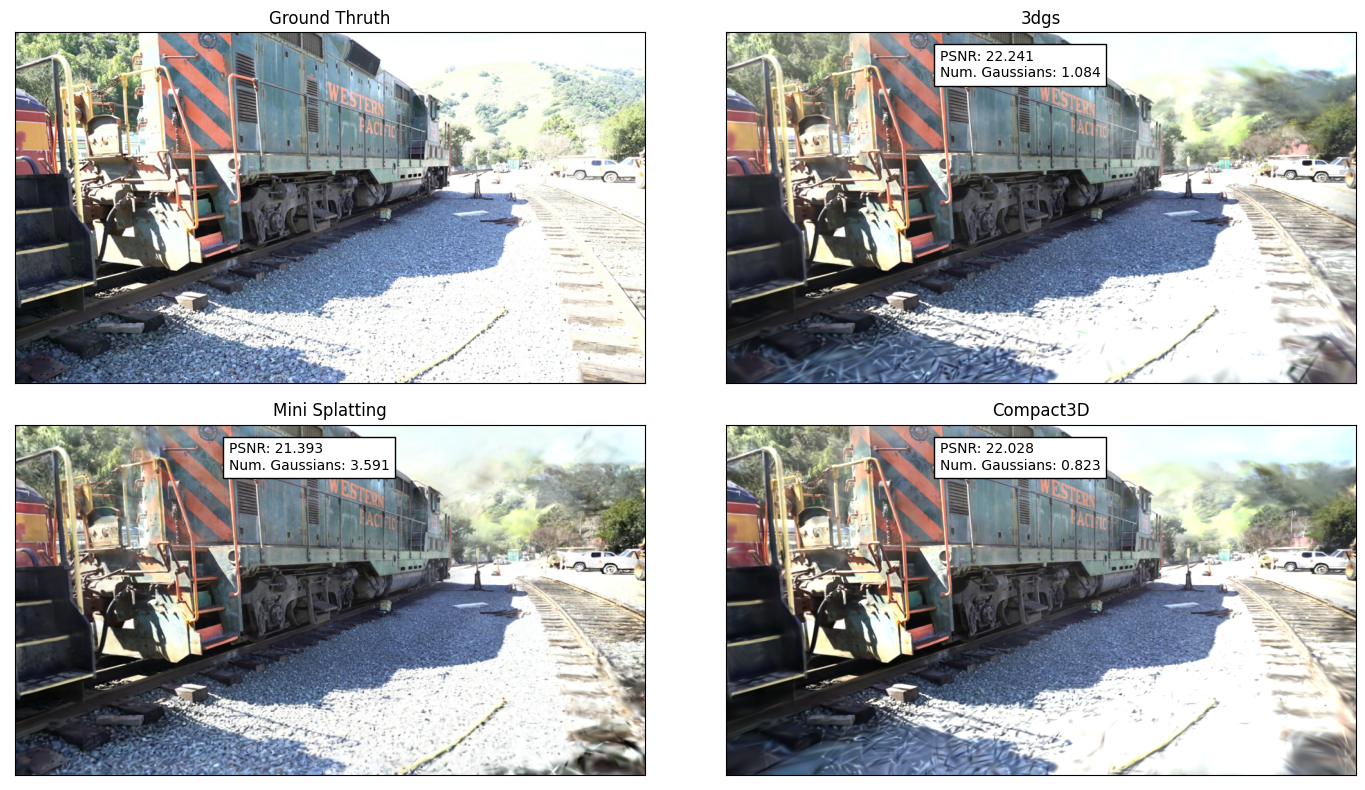

In [8]:
# Plot the density (where are gaussians where not) for a specific image from the bicycle dataset for 3dgsinal,Mini Splatting and Compact3D
import sys
import os
sys.path.insert(0, os.path.join(sys.path[0], "../"))
import torch
from utils.image_utils import psnr
from lpipsPyTorch import lpips
from utils.loss_utils import l1_loss, ssim

img_width = 0
img_height = 0
fig,axs = plt.subplots(2,2)
axs = axs.flatten()
remove_ticks = lambda *axs : [(ax.set_xticks([]),ax.set_xticklabels([]),ax.set_yticks([]),ax.set_yticklabels([])) for ax in axs]

for y,exp in enumerate(["3dgs","mini","compact3d"]):
    render_img = Image.open(os.path.join(eval_paths[exp]["training ckpt"]["train"],"renders","00014.png"))
    img_width,img_height = render_img.width,render_img.height
    #gt_img = Image.open(os.path.join(eval_paths[exp][comp]["train"],"gt","00003.png"))
    #psnr_val = round(psnr(torch.tensor(np.asarray(render_img)/255).permute(2,0,1),torch.tensor(np.asarray(gt_img)/255).permute(2,0,1)).mean().double().cpu().detach().numpy().item(),3)
    psnr_val = round(stats[exp]["training ckpt"]["train"]["psnr"],3)
    num_gauss = round(stats[exp]["training ckpt"]["train"]["num_gaussians"]/1e6,3)
    axs[y+1].imshow(render_img)
    axs[y+1].text(0.34, 0.95, f"PSNR: {psnr_val} \nNum. Gaussians: {num_gauss}", transform=axs[y+1].transAxes, fontsize=10,verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

    #axs[x][0].set_ylabel(comp,fontsize=12)
remove_ticks(*[ax for ax in axs.flatten()])

gt_img = Image.open(os.path.join(eval_paths[exp][comp]["train"],"gt","00014.png"))
axs[0].imshow(gt_img)
axs[0].set_title("Ground Thruth")
axs[1].set_title("3dgs")
axs[2].set_title("Mini Splatting")
axs[3].set_title("Compact3D")
#axs[4].set_title("Mini Splatting + Opacity Reg.")

fig.set_size_inches(8*((1*img_width)/(1*img_height)),8)
fig.tight_layout()
fig.savefig('./plots/compare_train_train.png', dpi=600,bbox_inches="tight")
fig.savefig('./plots/compare_train_train_lowq.png', dpi=100,bbox_inches="tight")

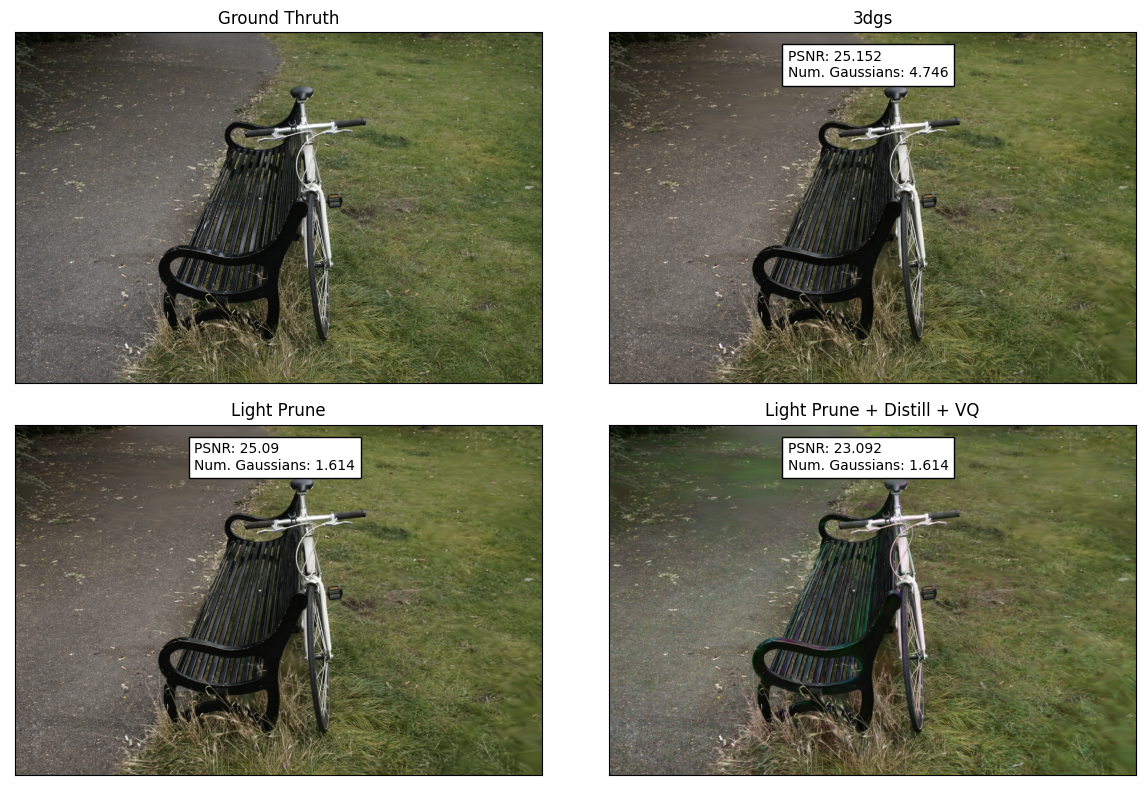

In [7]:
# Plot the density (where are gaussians where not) for a specific image from the bicycle dataset for 3dgsinal,Mini Splatting and Compact3D
import sys
import os
sys.path.insert(0, os.path.join(sys.path[0], "../"))
import torch
from utils.image_utils import psnr
from lpipsPyTorch import lpips
from utils.loss_utils import l1_loss, ssim

img_width = 0
img_height = 0
fig,axs = plt.subplots(2,2)
axs = axs.flatten()
remove_ticks = lambda *axs : [(ax.set_xticks([]),ax.set_xticklabels([]),ax.set_yticks([]),ax.set_yticklabels([])) for ax in axs]
exp = "3dgs"
for y,comp in enumerate(["training ckpt","light prune", "light prune + distill + vq"]):
    render_img = Image.open(os.path.join(eval_paths[exp][comp]["bicycle"],"renders","00014.png"))
    img_width,img_height = render_img.width,render_img.height
    #gt_img = Image.open(os.path.join(eval_paths[exp][comp]["train"],"gt","00003.png"))
    #psnr_val = round(psnr(torch.tensor(np.asarray(render_img)/255).permute(2,0,1),torch.tensor(np.asarray(gt_img)/255).permute(2,0,1)).mean().double().cpu().detach().numpy().item(),3)
    psnr_val = round(stats[exp][comp]["bicycle"]["psnr"],3)
    num_gauss = round(stats[exp][comp]["bicycle"]["num_gaussians"]/1e6,3)
    axs[y+1].imshow(render_img)
    axs[y+1].text(0.34, 0.95, f"PSNR: {psnr_val} \nNum. Gaussians: {num_gauss}", transform=axs[y+1].transAxes, fontsize=10,verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

    #axs[x][0].set_ylabel(comp,fontsize=12)
remove_ticks(*[ax for ax in axs.flatten()])

gt_img = Image.open(os.path.join(eval_paths[exp][comp]["bicycle"],"gt","00014.png"))
axs[0].imshow(gt_img)
axs[0].set_title("Ground Thruth")
axs[1].set_title("3dgs")
axs[2].set_title("Light Prune")
axs[3].set_title("Light Prune + Distill + VQ")
#axs[4].set_title("Mini Splatting + Opacity Reg.")

fig.set_size_inches(8*((1*img_width)/(1*img_height)),8)
fig.tight_layout()
fig.savefig('./plots/compare_light_gauss.png', dpi=600,bbox_inches="tight")
fig.savefig('./plots/compare_light_gauss_lowq.png', dpi=100,bbox_inches="tight")

In [3]:


event_accs_fn = lambda names,paths : {name : EventAccumulator(path,size_guidance={"images" : False,'histograms': False,}) for name,path in zip(names,paths)}


event_accs = event_accs_fn(["3dgs","mini","compact3d","mini + opacity reg."],
                            [f"../output/{sp}/bicycle" for sp in ["orig","mini","compact3d","mini_opacity"]])



for event_acc in event_accs.values():
    event_acc.Reload()



In [4]:
print(mean_fn([event.value for event in event_accs["3dgs"].Scalars("iter_time")]))
print(mean_fn([event.value for event in event_accs["mini"].Scalars("iter_time")]))
print(mean_fn([event.value for event in event_accs["compact3d"].Scalars("iter_time")]))
print(mean_fn([event.value for event in event_accs["mini + opacity reg."].Scalars("iter_time")]))

24.461258374881744
34.98441816883087
67.04614568328857
31.156437465953825


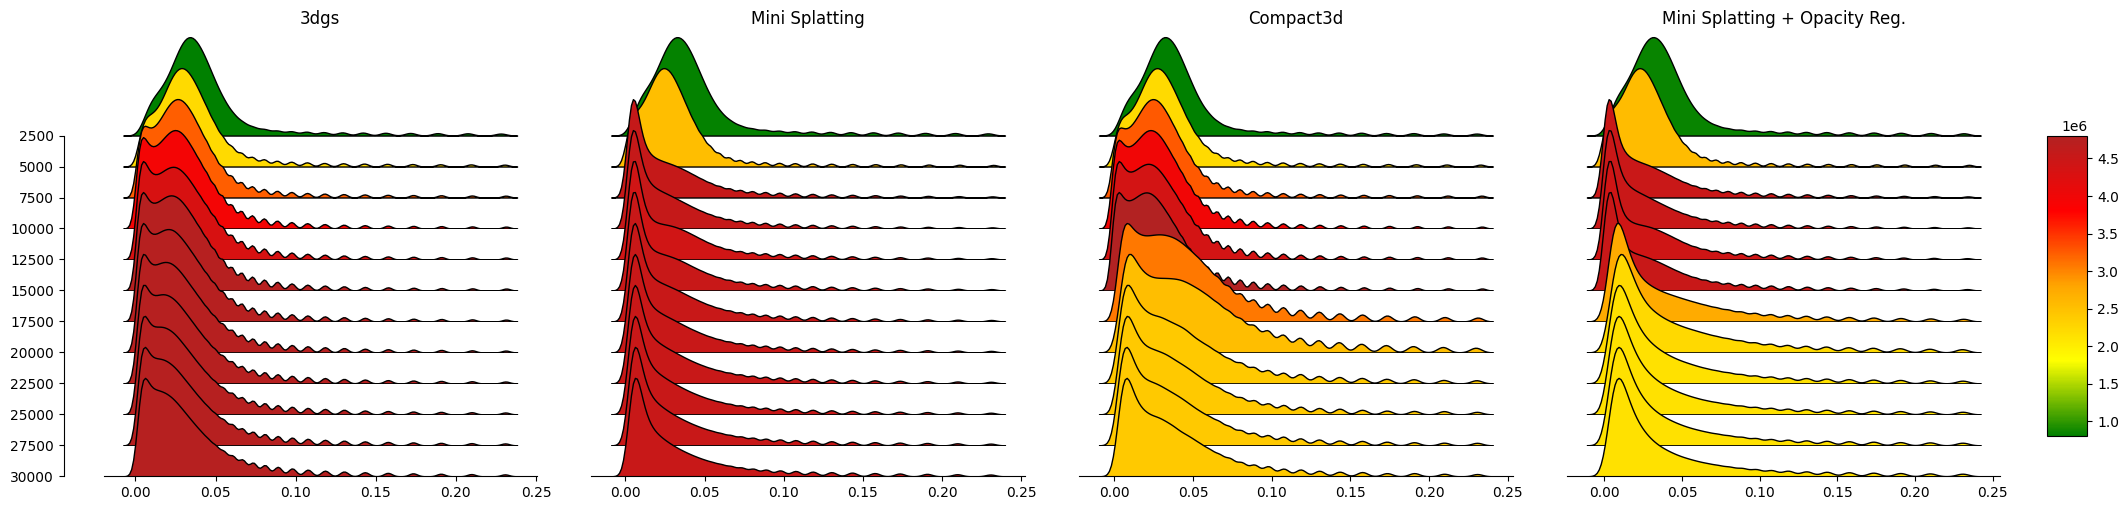

In [5]:
fig,axs = plot_histograms([event_acc.Histograms("scene/size_histogram") for event_acc in subdict(event_accs,"3dgs","mini","compact3d","mini + opacity reg.").values()],scaling=10,upper_cutoff=0.25)
fig.set_size_inches(axs.shape[1]*5,5)
axs[0][0].set_title("3dgs")
axs[0][1].set_title("Mini Splatting")
axs[0][2].set_title("Compact3d")
axs[0][3].set_title("Mini Splatting + Opacity Reg.")
fig.savefig('./plots/opacity_hist.png', dpi=600,bbox_inches="tight")
fig.savefig('./plots/opacity_hist_lowq.png', dpi=100,bbox_inches="tight")

#fig,axs = plot_histograms([event_acc.Histograms("scene/opacity_histogram") for event_acc in subdict(event_accs,"3dgs","mini","compact3d","mini + opacity reg.").values()],scaling=10)
#fig.set_size_inches(axs.shape[1]*5,5)
#axs[0][0].set_title("3dgs")
#axs[0][1].set_title("Mini Splatting")
#axs[0][2].set_title("Compact3d")
#axs[0][3].set_title("Mini Splatting + Opacity Reg.")
#fig.savefig('./plots/opacity_hist.png', dpi=600,bbox_inches="tight")
#fig.savefig('./plots/opacity_hist_lowq.png', dpi=100,bbox_inches="tight")

In [12]:
import sys
import os
sys.path.insert(0, os.path.join(sys.path[0], "../"))


from light_gauss.scene.gaussian_model import GaussianModel as LightGaussianModel
light_gaussian = LightGaussianModel(3)
light_gaussian.load_ply("../output/mini/light_prune_0.66_1_0.1_v_important_score/train/point_cloud/iteration_5000/point_cloud.ply")

from scene.gaussian_model import GaussianModel
gaussian = GaussianModel(3)
gaussian.load_ply("../output/mini/train/point_cloud/iteration_30000/point_cloud.ply")

ic| self.max_sh_degree: 3
ic| 3 * (self.max_sh_degree + 1) ** 2 - 3: 45


load quant: False
quant params: []


<AxesSubplot:ylabel='Density'>

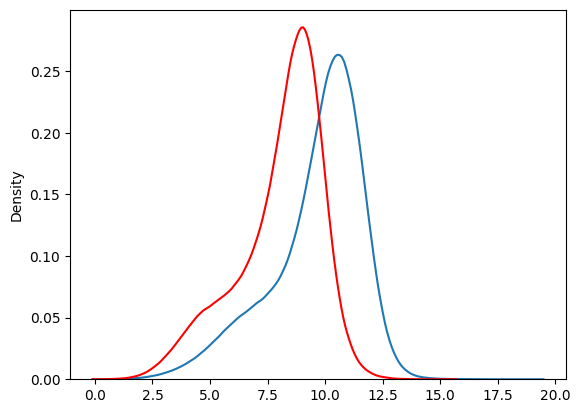

In [17]:
import torch
sns.kdeplot(x=torch.linalg.norm(gaussian._scaling,dim=-1).cpu().detach().numpy(),ax=plt.gca())
sns.kdeplot(x=torch.linalg.norm(light_gaussian._scaling,dim=-1).cpu().detach().numpy(),color="red",ax=plt.gca())

<AxesSubplot:ylabel='Density'>

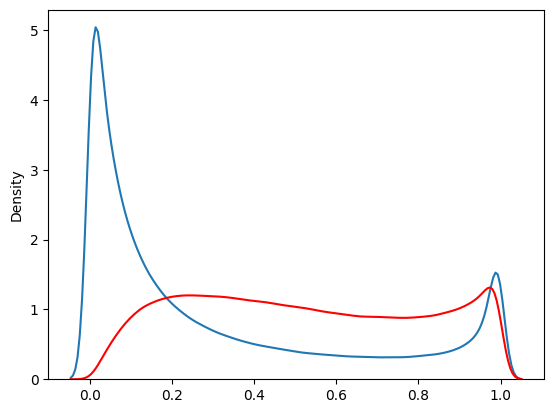

In [13]:
sns.kdeplot(x=gaussian.get_opacity[:,0].cpu().detach().numpy(),ax=plt.gca())
sns.kdeplot(x=light_gaussian.get_opacity[:,0].cpu().detach().numpy(),color="red",ax=plt.gca())

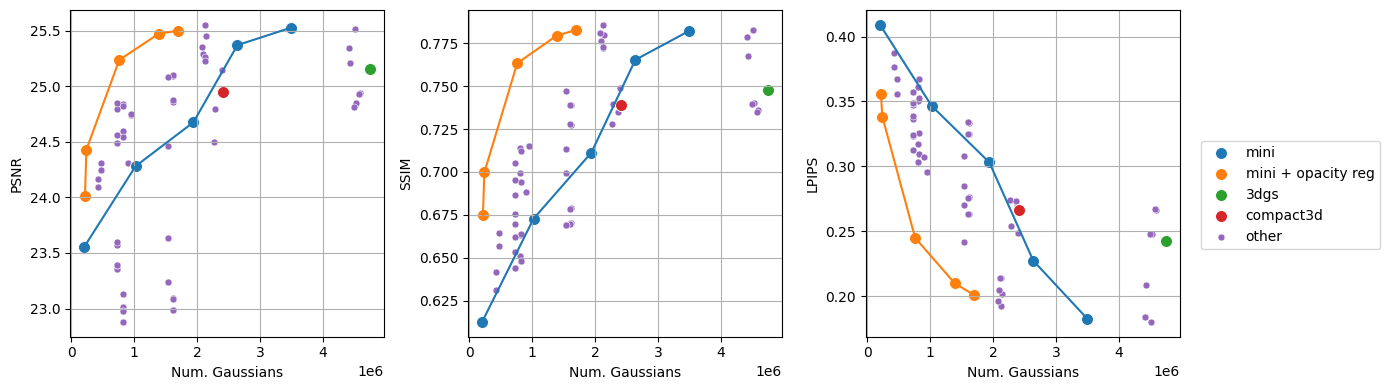

In [18]:
# Plot (PSNT,SSIM,LPIPS) vs num Gaussians for the bicycle dataset
did_other_label = False
fig,axs = plt.subplots(1,3)
colors = list(sns.color_palette())
for x,y in enumerate(["psnr","ssim","lpips"]):

    for exp in ["3dgs","3dgs + depth reg.","3dgs + opacity reg.","compact3d","mini","mini + compact3d","mini + opacity reg."]:
        for comp in ["training ckpt","mini_s","c3dgs","light prune", "light prune + distill + vq", "light prune 2", "light prune 3 + distill + vq","light prune 3","light prune 3 + distill + vq"]:
            if (exp == "3dgs" or exp == "compact3d") and comp == "training ckpt":
                continue
            if "bicycle" in stats[exp][comp]:
                if not did_other_label:
                    sns.scatterplot(x=[stats[exp][comp]["bicycle"]["num_gaussians"]],y=[stats[exp][comp]["bicycle"][y]],ax=axs[x],s=25,color=colors[4],label="other")
                    did_other_label = True
                else:
                    sns.scatterplot(x=[stats[exp][comp]["bicycle"]["num_gaussians"]],y=[stats[exp][comp]["bicycle"][y]],ax=axs[x],s=25,color=colors[4])

    sns.scatterplot(x=[stats[f"mini_{i}"]["training ckpt"]["bicycle"]["num_gaussians"] for i in [1,3,5,7,8]],y=[stats[f"mini_{i}"]["training ckpt"]["bicycle"][y] for i in [1,3,5,7,8]],color=colors[0],ax=axs[x],s=75,label="mini")
    sns.lineplot(x=[stats[f"mini_{i}"]["training ckpt"]["bicycle"]["num_gaussians"] for i in [1,3,5,7,8]],y=[stats[f"mini_{i}"]["training ckpt"]["bicycle"][y] for i in [1,3,5,7,8]],color=colors[0],ax=axs[x])

    sns.scatterplot(x=[stats[f"mini_opacity_{i}"]["training ckpt"]["bicycle"]["num_gaussians"] for i in [1,2,5,6,7]],y=[stats[f"mini_opacity_{i}"]["training ckpt"]["bicycle"][y] for i in [1,2,5,6,7]],color=colors[1],ax=axs[x],s=75,label="mini + opacity reg")
    sns.lineplot(x=[stats[f"mini_opacity_{i}"]["training ckpt"]["bicycle"]["num_gaussians"] for i in [1,2,5,6,7]],y=[stats[f"mini_opacity_{i}"]["training ckpt"]["bicycle"][y] for i in [1,2,5,6,7]],color=colors[1],ax=axs[x])
    
    sns.scatterplot(x=[stats[f"3dgs"]["training ckpt"]["bicycle"]["num_gaussians"]],y=[stats[f"3dgs"]["training ckpt"]["bicycle"][y]],ax=axs[x],s=75,color=colors[2],label="3dgs")
    sns.scatterplot(x=[stats[f"compact3d"]["training ckpt"]["bicycle"]["num_gaussians"]],y=[stats[f"compact3d"]["training ckpt"]["bicycle"][y]],ax=axs[x],s=75,color=colors[3],label="compact3d")


    axs[x].grid(True)
    axs[x].get_legend().remove()

axs[0].set_ylabel("PSNR")
axs[1].set_ylabel("SSIM")
axs[2].set_ylabel("LPIPS")

axs[0].set_xlabel("Num. Gaussians")
axs[1].set_xlabel("Num. Gaussians")
axs[2].set_xlabel("Num. Gaussians")

handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[1],handles[2],handles[3],handles[4],handles[0]]
labels = [labels[1],labels[2],labels[3],labels[4],labels[0]]

fig.legend(handles,labels,loc='center right',ncol=1,frameon=True,bbox_to_anchor=(1.16, 0.5),)

fig.set_size_inches(12,4)
fig.tight_layout()
fig.savefig('./plots/psnr_ssim_lpips_vs_num_gaussians.png', dpi=600,bbox_inches="tight")
fig.savefig('./plots/psnr_ssim_lpips_vs_num_gaussians_lowq.png', dpi=100,bbox_inches="tight")

In [19]:
"""
# Plot (PSNT,SSIM,LPIPS) vs num Gaussians for the bicycle dataset
fig,axs = plt.subplots(1,2)
colors = list(sns.color_palette())
for x,y in enumerate(["fps","size",]):

    for i,exp in enumerate(["3dgs","3dgs + depth reg.","3dgs + opacity reg.","compact3d","mini","mini + compact3d","mini + opacity reg."]):
        x_agg = []
        y_agg = []
        for comp in ["training ckpt","mini_s","c3dgs","light prune", "light prune + distill + vq"]:#, "light prune 2", "light prune 3 + distill + vq","light prune 3","light prune 3 + distill + vq"]:
            for ds in datasets:
                if ds in stats[exp][comp]:
                    if y in stats[exp][comp][ds]:
                        x_agg.append(stats[exp][comp][ds]["num_gaussians"])
                        y_agg.append(stats[exp][comp][ds][y])
        sns.scatterplot(x=[np.mean(x_agg)],y=[np.mean(y_agg)],ax=axs[x],s=75,color=colors[i],label=exp)
        print(exp,": ",(np.asarray(x_agg)/np.asarray(y_agg)).mean())
    #sns.scatterplot(x=[stats[f"mini_{i}"]["training ckpt"]["bicycle"]["num_gaussians"] for i in [1,3,5,7,8]],y=[stats[f"mini_{i}"]["training ckpt"]["bicycle"][y] for i in [1,3,5,7,8]],color=colors[0],ax=axs[x],s=75,label="mini")
    #sns.lineplot(x=[stats[f"mini_{i}"]["training ckpt"]["bicycle"]["num_gaussians"] for i in [1,3,5,7,8]],y=[stats[f"mini_{i}"]["training ckpt"]["bicycle"][y] for i in [1,3,5,7,8]],color=colors[0],ax=axs[x])

    #sns.scatterplot(x=[stats[f"mini_opacity_{i}"]["training ckpt"]["bicycle"]["num_gaussians"] for i in [1,2,5,6,7]],y=[stats[f"mini_opacity_{i}"]["training ckpt"]["bicycle"][y] for i in [1,2,5,6,7]],color=colors[1],ax=axs[x],s=75,label="mini + opacity reg")
    #sns.lineplot(x=[stats[f"mini_opacity_{i}"]["training ckpt"]["bicycle"]["num_gaussians"] for i in [1,2,5,6,7]],y=[stats[f"mini_opacity_{i}"]["training ckpt"]["bicycle"][y] for i in [1,2,5,6,7]],color=colors[1],ax=axs[x])
    
    #sns.scatterplot(x=[stats[f"3dgs"]["training ckpt"]["bicycle"]["num_gaussians"]],y=[stats[f"3dgs"]["training ckpt"]["bicycle"][y]],ax=axs[x],s=75,color=colors[2],label="3dgs")
    #sns.scatterplot(x=[stats[f"compact3d"]["training ckpt"]["bicycle"]["num_gaussians"]],y=[stats[f"compact3d"]["training ckpt"]["bicycle"][y]],ax=axs[x],s=75,color=colors[3],label="compact3d")

    axs[x].grid(True)
    axs[x].get_legend().remove()

axs[0].set_title("fps vs Num Gaussians")
axs[1].set_title("size vs Num Gaussians")

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles,labels,loc='center right',ncol=1,frameon=True,bbox_to_anchor=(1.075, 0.5),)

fig.set_size_inches(12,4)
"""

'\n# Plot (PSNT,SSIM,LPIPS) vs num Gaussians for the bicycle dataset\nfig,axs = plt.subplots(1,2)\ncolors = list(sns.color_palette())\nfor x,y in enumerate(["fps","size",]):\n\n    for i,exp in enumerate(["3dgs","3dgs + depth reg.","3dgs + opacity reg.","compact3d","mini","mini + compact3d","mini + opacity reg."]):\n        x_agg = []\n        y_agg = []\n        for comp in ["training ckpt","mini_s","c3dgs","light prune", "light prune + distill + vq"]:#, "light prune 2", "light prune 3 + distill + vq","light prune 3","light prune 3 + distill + vq"]:\n            for ds in datasets:\n                if ds in stats[exp][comp]:\n                    if y in stats[exp][comp][ds]:\n                        x_agg.append(stats[exp][comp][ds]["num_gaussians"])\n                        y_agg.append(stats[exp][comp][ds][y])\n        sns.scatterplot(x=[np.mean(x_agg)],y=[np.mean(y_agg)],ax=axs[x],s=75,color=colors[i],label=exp)\n        print(exp,": ",(np.asarray(x_agg)/np.asarray(y_agg)).mean())\

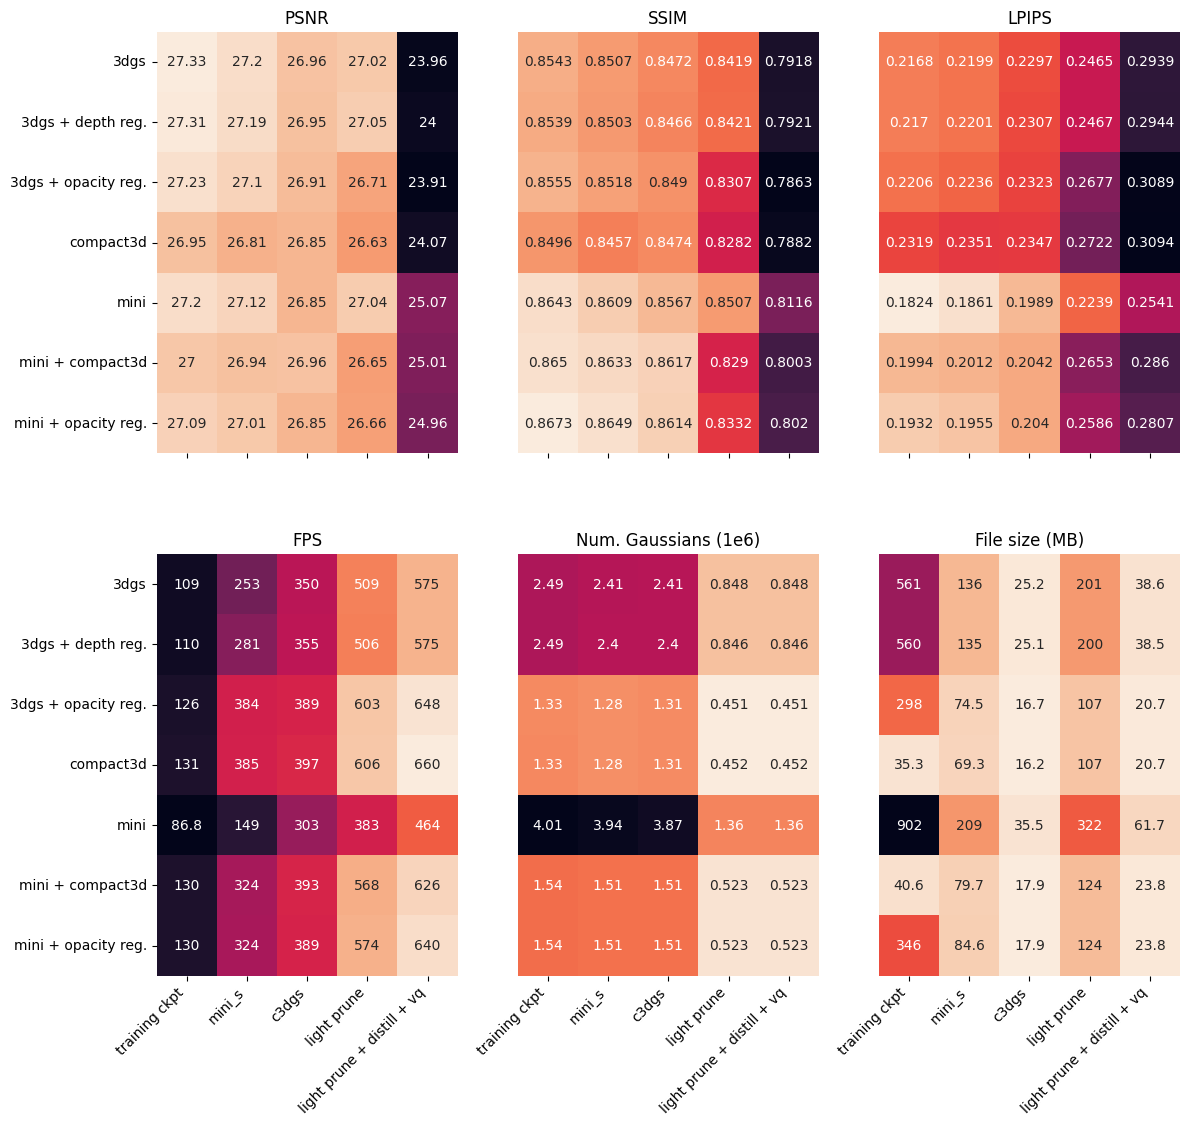

In [12]:
exps = ["3dgs","3dgs + depth reg.","3dgs + opacity reg.","compact3d","mini","mini + compact3d","mini + opacity reg."]
compressions = ["training ckpt","mini_s","c3dgs","light prune", "light prune + distill + vq"]
vslabels = [["psnr","ssim","lpips"],["fps","num_gaussians","size"]]
table_stats = copy.deepcopy(stats)
table_stats = {key : {comp_key : comp_val for comp_key,comp_val in val.items() if comp_key in compressions} for key,val in table_stats.items() if key in exps}
table_stats_normalized,table_min_max = normalize_stats(table_stats,datasets)
merge_psnr_ssim_lpips(table_stats_normalized)

fig,axs = plt.subplots(2,3,sharex=True)

for ax_x,vslabel in enumerate(vslabels):
    for ax_y,y in enumerate(vslabel):
        data = np.zeros((len(exps),len(compressions)))
        ratio = np.zeros((len(exps),len(compressions)))
        norm = np.zeros_like(data)
        for dx,exp in enumerate(exps):
            for dy,compression in enumerate(compressions):
                for ds in datasets:
                    if y == "psl":
                        tbst = table_stats_normalized
                    else:
                        tbst = table_stats
                    if compression in tbst[exp].keys():
                        if ds in tbst[exp][compression].keys():
                            if y in tbst[exp][compression][ds].keys():
                                data[dx,dy] += tbst[exp][compression][ds][y]
                                norm[dx,dy] += 1
        
            
        norm = np.where(norm == 0, 1, norm)
        data = data/norm

        if y == "num_gaussians":
            data /= 1e6


        fmt = ".4g" if ax_x == 0 else ".3g"
        cmap = sns.color_palette("rocket",as_cmap=True) if y in ["psnr","ssim","fps"] else sns.color_palette("rocket_r",as_cmap=True)
        if ax_y == 0:
            sns.heatmap(data,ax=axs[ax_x][ax_y],yticklabels=exps,xticklabels=compressions,cbar=False,annot=True,square=True,fmt=fmt,cmap=cmap)
        else:
            sns.heatmap(data,ax=axs[ax_x][ax_y],yticklabels=[],xticklabels=compressions,cbar=False,annot=True,square=True,fmt=fmt,cmap=cmap)

        axs[ax_x][ax_y].set_xticklabels(axs[ax_x][ax_y].get_xticklabels(),rotation=45,ha="right")
        #axs[0][x].tick_params("x", rotation=70,ha="right")

axs[0][0].set_title("PSNR")
axs[0][1].set_title("SSIM")
axs[0][2].set_title("LPIPS")
axs[1][0].set_title("FPS")
axs[1][1].set_title("Num. Gaussians (1e6)")
axs[1][2].set_title("File size (MB)")

fig.set_size_inches(12,12)
fig.tight_layout()
fig.savefig('./plots/stats.png', dpi=600,bbox_inches="tight")
fig.savefig('./plots/stats_lowq.png', dpi=100,bbox_inches="tight")

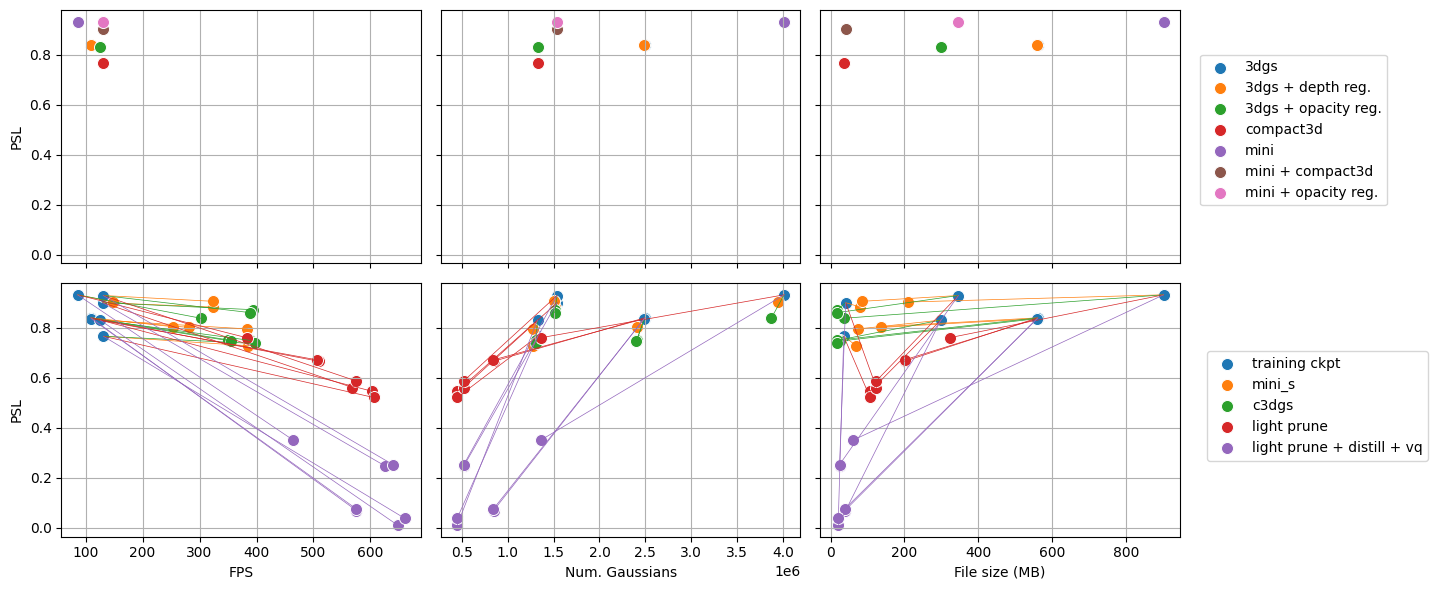

In [21]:
from matplotlib.patches import ConnectionPatch
exps = ["3dgs","3dgs + depth reg.","3dgs + opacity reg.","compact3d","mini","mini + compact3d","mini + opacity reg."]
compressions = ["training ckpt", "mini_s","c3dgs","light prune", "light prune + distill + vq"]
vslabels = ["psl","fps","num_gaussians","size"]
fig,axs = plt.subplots(2,len(vslabels)-1,sharey="all",sharex="col")
#axs = axs[None,:]
colors = list(sns.color_palette())

data = {comp : {vslabel : {} for vslabel in vslabels} for comp in compressions}
for dy,compression in enumerate(compressions):
    for x,y in enumerate(vslabels):
        for dx,exp in enumerate(exps):
            data_alloc = []
            for ds in datasets:
                if y == "psl":
                    tbst = table_stats_normalized
                else:
                    tbst = table_stats
                if compression in tbst[exp].keys():
                    if ds in tbst[exp][compression].keys():
                        if y in tbst[exp][compression][ds].keys():
                            data_alloc.append(tbst[exp][compression][ds][y])
                            
            data_alloc = np.asarray(data_alloc).mean()
            data[compression][y][exp] = data_alloc


for k,vslabel in enumerate(vslabels[1:]):
    for i,exp in enumerate(exps):
        #axs[1][k].add_artist(ConnectionPatch(xyA=[data["training ckpt"][vslabel][exp],data["training ckpt"]["psl"][exp]],
        #                xyB=[data["training ckpt"][vslabel][exp],data["training ckpt"]["psl"][exp]],
        #                coordsA="data", coordsB="data",
        #                axesA=axs[0][k],axesB=axs[1][k],
        #                color="black",
        #                linewidth=0.5
        #                ))
        sns.scatterplot(x=[data["training ckpt"][vslabel][exp]],y=[data["training ckpt"]["psl"][exp] ],ax=axs[0][k],s=75,color=colors[i],label=exp)
        

for k,vslabel in enumerate(vslabels[1:]):
    for i,comp in enumerate(compressions):
        x_data = [data[comp][vslabel][exp] for exp in exps]
        y_data = [data[comp]["psl"][exp] for exp in exps]
        
        if comp != "training ckpt":
            x_data_3dgs = [data["training ckpt"][vslabel][exp] for exp in exps]
            y_data_3dgs = [data["training ckpt"]["psl"][exp] for exp in exps]
            for (x1,y1,x2,y2) in zip(x_data,y_data,x_data_3dgs,y_data_3dgs):
                sns.lineplot(x=[x1,x2],y=[y1,y2],ax=axs[1][k],color=colors[i],linewidth=0.5)
        
        sns.scatterplot(x=x_data,y=y_data,ax=axs[1][k],s=75,color=colors[i],label=comp)

        
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles,labels,loc='center right',ncol=1,frameon=True,bbox_to_anchor=(1.166, 0.775),)

handles, labels = axs[1][0].get_legend_handles_labels()
fig.legend(handles,labels,loc='center right',ncol=1,frameon=True,bbox_to_anchor=(1.2, 0.315),)

for ax in axs.flatten():
    ax.grid(True)
    if ax.get_legend():
        ax.get_legend().remove()

axs[0,0].set_ylabel("PSL")
axs[1,0].set_ylabel("PSL")
axs[1,0].set_xlabel("FPS")
axs[1,1].set_xlabel("Num. Gaussians")
axs[1,2].set_xlabel("File size (MB)")
#axs[0,0].set_title("PSL vs FPS")
#axs[0,1].set_title("PSL vs Num. Gaussians")
#axs[0,2].set_title("PSL vs File Size (MB)")
fig.set_size_inches(12,6)
fig.tight_layout()
fig.savefig('./plots/after_train_compressions.png', dpi=600,bbox_inches="tight")
fig.savefig('./plots/after_train_compressions_lowq.png', dpi=100,bbox_inches="tight")